In [ ]:
!python -m pip install --upgrade pip
!pip install --upgrade supervision
!pip install transformers
!pip install pytorch-lightning
!pip install timm
!pip install cython
!pip install pycocotools
!pip install scipy

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.3 MB/s eta 0:00:00


# CREA MODELLO

In [ ]:
import os
import torchvision
from transformers import DetrFeatureExtractor, DetrForObjectDetection

dataset = 'drive/MyDrive/Colab/Dataset'

ANNOTATION_FILE_NAME = "annotations.json"
TRAIN_DIRECTORY = os.path.join(dataset, "Train")
VAL_DIRECTORY = os.path.join(dataset, "Val")
TEST_DIRECTORY = os.path.join(dataset, "Test")

#caricamento del modello preaddestrato
CHECKPOINT = "facebook/detr-resnet-50"
feature_extractor = DetrFeatureExtractor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(pretrained_model_name_or_path=CHECKPOINT, ignore_mismatched_sizes=True)

#classe per la lettura delle annotazioni
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        feature_extractor,
        model,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.feature_extractor = feature_extractor
        self.model = model

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}

        # Use the feature extractor to prepare the image and annotations
        encoding = self.feature_extractor(images=images, annotations=annotations, return_tensors="pt")

        # Get the pixel values and labels
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, feature_extractor=feature_extractor, model=model, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, feature_extractor=feature_extractor, model=model, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, feature_extractor=feature_extractor, model=model, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


loading annotations into memory...
Done (t=5.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Number of training examples: 1568
Number of validation examples: 192
Number of test examples: 180


In [ ]:
from torch.utils.data import DataLoader

#caricamento dei dataloader del dataset
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        self.model.train()
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        self.model.eval()
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
#configura i pesi del modello
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
from pytorch_lightning import Trainer

#addestra e salva il modello
model.train()
MAX_EPOCHS = 120
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)
trainer.fit(model)

MODEL_PATH = 'drive/MyDrive/Colab/Custom_model'
model.model.save_pretrained(MODEL_PATH)

model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | train
---------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)
399       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=120` reached.


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

# fine crea modello

# CREA FILE PREDIZIONI

In [ ]:
from transformers import DetrForObjectDetection, DetrFeatureExtractor
import torch
from PIL import Image
import requests
import os
import json
import pickle

#ottiene tutte le predizioni dell'immagine e ritorna quella con confidenza massima
def get_predictions(name):
    image = Image.open(name).convert("RGB")

   #carica il nuovo modello e utilizza il preaddestrato per l'estrazione delle features
    processor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    model = DetrForObjectDetection.from_pretrained("drive/MyDrive/Colab/Custom_model", revision="no_timm")

    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # Post-process for COCO API format
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0)[0]

    # Find the highest score above the threshold
    max_score = torch.max(results["scores"]).item()
    if max_score > 0:
        # Get the corresponding label and bounding box for the highest score
        highest_score_idx = torch.argmax(results["scores"]).item()
        highest_label = model.config.id2label[results["labels"][highest_score_idx].item()]
        highest_box = [round(i, 2) for i in results["boxes"][highest_score_idx].tolist()]

        print(f"Detected {highest_label} with confidence {round(max_score, 3)} at location {highest_box}")

        return highest_box, round(max_score, 3)

#ottieni la bounding box dal file di annotazione
def get_bounding_box(image_name, data):

  # Find the id of the image in the dataset
  image_id = None
  for img in data['images']:
    if img['file_name'] == image_name:
      image_id = img['id']
      break

  if image_id is None:
    print('nessun file', image_name)
    return

  # Find the annotation corresponding to the image
  for anno in data['annotations']:
    if anno['image_id'] == image_id:
      bbox = anno['bbox']
      bbox[2] = bbox[0] + bbox[2]
      bbox[3] = bbox[1] + bbox[3]
      return bbox
  return [0]


def main():

    #ottieni le predizioni per tutte le immagini
    predictions = []
    img_path = 'drive/MyDrive/Colab/Dataset/Test/'

    with open(os.path.join(img_path, 'annotations.json'), 'r') as f:
        data = json.load(f)

        for root, dirs, files in os.walk(img_path):
            for file in files:
                if not file.endswith('json'):
                  print(file)

                  bbox = get_bounding_box(file, data)
                  #se la bounding box è non nulla, inserisci in una lista le informazioni sulla box predetta
                  if bbox is not None:
                    print(bbox)

                    predicted_box, confidence = get_predictions(img_path + file)

                    predictions.append({
                    'name': file,
                    'bbox': bbox,
                    'predicted_bbox': predicted_box,
                    'confidence': confidence
                    })

        # Salva le predizioni in un file pickle
    with open('drive/MyDrive/Colab/Data/predictions.pkl', 'wb') as f:
        pickle.dump(predictions, f)


if __name__ == '__main__':
    main()



27[:, :, 101].png
[220, 138, 239, 159]


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


Detected LABEL_0 with confidence 0.021 at location [193.44, 111.95, 208.57, 130.63]
27[:, :, 102].png
[227, 141, 242, 152]
Detected LABEL_0 with confidence 0.008 at location [231.34, 331.79, 255.24, 349.19]
-27[114, :, :].png
[0]
Detected LABEL_0 with confidence 0.005 at location [87.1, 220.42, 90.31, 235.18]
-27[:, 116, :].png
[0]
Detected LABEL_0 with confidence 0.0 at location [64.65, 301.25, 69.21, 318.71]
27[142, :, :].png
[97, 223, 103, 241]
Detected LABEL_0 with confidence 0.02 at location [99.7, 226.34, 102.61, 237.87]
27[144, :, :].png
[97, 224, 103, 243]
Detected LABEL_0 with confidence 0.423 at location [99.48, 228.49, 102.48, 240.85]
27[149, :, :].png
[96, 222, 103, 245]
Detected LABEL_0 with confidence 0.017 at location [99.23, 224.92, 102.56, 241.77]
27[150, :, :].png
[95, 222, 103, 245]
Detected LABEL_0 with confidence 0.02 at location [99.72, 226.97, 102.63, 240.97]
27[152, :, :].png
[95, 218, 102, 245]
Detected LABEL_0 with confidence 0.901 at location [99.34, 226.7, 1

#STAMPA METRICHE

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

#calcola la intersection over union della bbox predetta con quella annotata
def calculate_iou(box1, box2):

  # Calcola le coordinate dell'intersezione
  x1 = max(box1[0], box2[0])
  y1 = max(box1[1], box2[1])
  x2 = min(box1[2], box2[2])
  y2 = min(box1[3], box2[3])

  # Calcola l'area dell'intersezione
  intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

  # Calcola l'area delle due bounding box
  box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
  box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

  # Calcola l'unione delle due bounding box
  union = box1_area + box2_area - intersection

  # Calcola l'IoU
  iou = intersection / union if union > 0 else 0

  return iou


def main():

    threshold = 0
    iou_threshold = 0.3
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    with open('drive/MyDrive/Colab/Data/predictions.pkl', 'rb') as f:
      predictions = pickle.load(f)

    #stamap le metriche per ogni valore di tolleranza da 0.1 a 0.9
    for i in range (0, 10):
      threshold = i/10
      for pred in predictions:
        #per ogni elemento nella lista delle predizioni, calcola se si ha TP, FN, TN o FP
        #se la bbox predetta ha un valore di IoU con la bbox annotata inferiore alla threshold, viene considerato FN

        if len(pred['bbox']) > 1:
          if pred['confidence'] >= threshold:
            if calculate_iou(pred['bbox'], pred['predicted_bbox']) >= iou_threshold:
              tp += 1
            else:
              fn += 1
          else:
            fn += 1

        else:
          if pred['confidence'] >= threshold:
            fp += 1
          else:
            tn += 1

      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      accuracy = (tp + tn) / (tp + tn + fp + fn)
      f1_score = 2 * (precision * recall) / (precision + recall)

      print("\nThreshold:", threshold)
      print("Precision:", precision)
      print("Recall:", recall)
      print("Accuracy:", accuracy)
      print("F1 Score:", f1_score)

if __name__ == '__main__':
    main()


Threshold: 0.5
Precision: 0.8356164383561644
Recall: 0.648936170212766
Accuracy: 0.75
F1 Score: 0.7305389221556887

Threshold: 0.51
Precision: 0.8356164383561644
Recall: 0.648936170212766
Accuracy: 0.75
F1 Score: 0.7305389221556887

Threshold: 0.52
Precision: 0.8356164383561644
Recall: 0.648936170212766
Accuracy: 0.75
F1 Score: 0.7305389221556887

Threshold: 0.53
Precision: 0.8356164383561644
Recall: 0.648936170212766
Accuracy: 0.75
F1 Score: 0.7305389221556887

Threshold: 0.54
Precision: 0.8379120879120879
Recall: 0.648936170212766
Accuracy: 0.7511111111111111
F1 Score: 0.7314148681055156

Threshold: 0.55
Precision: 0.8413793103448276
Recall: 0.648936170212766
Accuracy: 0.7527777777777778
F1 Score: 0.7327327327327327

Threshold: 0.56
Precision: 0.8438735177865613
Recall: 0.648936170212766
Accuracy: 0.753968253968254
F1 Score: 0.7336769759450172

Threshold: 0.57
Precision: 0.8457538994800693
Recall: 0.648936170212766
Accuracy: 0.7548611111111111
F1 Score: 0.7343867569601203

Threshold

# CONFRONTA BBOX

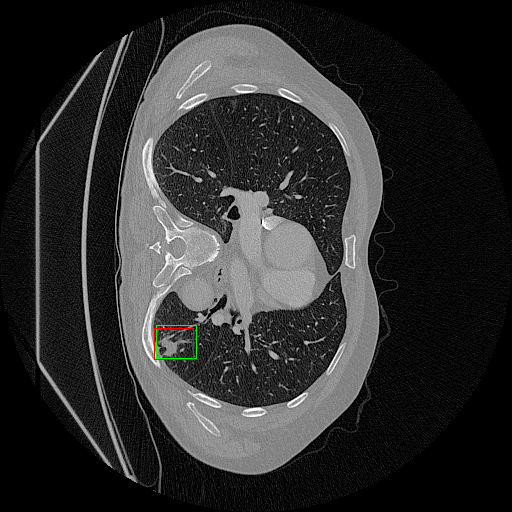

confidence:  0.997
iou:  0.7842028664012013


In [ ]:
import cv2
import pickle
import random
import os
from google.colab.patches import cv2_imshow

image_folder_path = 'drive/MyDrive/Colab/Dataset/Test'
with open('drive/MyDrive/Colab/Data/predictions.pkl', 'rb') as f:
    data = pickle.load(f)

#disegna la bounding box annotata (se esiste) e la bouunding box predetta con la confidenza più alta
#N.B. la bounding box predetta verrà utilizzata per il calcolo delle metriche solo se ha una confidenza superiore alle threshold
def draw_bounding_boxes(image_path, bbox, predicted_bbox):
    image = cv2.imread(image_path)

    # Se la bbox reale (verde) esiste, disegnala
    if len(bbox) > 1:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)

    # Disegna la bounding box predetta (rossa)
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = predicted_bbox
    x_min_pred = round(x_min_pred)
    y_min_pred = round(y_min_pred)
    x_max_pred = round(x_max_pred)
    y_max_pred = round(y_max_pred)
    cv2.rectangle(image, (x_min_pred, y_min_pred), (x_max_pred, y_max_pred), (0, 0, 255), 1)

    # Mostra l'immagine
    cv2_imshow(image)

# Scegli un elemento casuale dalla lista
random_element = random.choice(data)

# Estrai il nome del file immagine e le bounding box
image_name = random_element['name']
bbox = random_element['bbox']
predicted_bbox = random_element['predicted_bbox']

# Costruisci il percorso completo dell'immagine
image_path = os.path.join(image_folder_path, image_name)

# Chiama la funzione per disegnare le bounding box
draw_bounding_boxes(image_path, bbox, predicted_bbox)


#MODIFICA COLORI IMMAGINE

In [8]:
!pip install pytorch_lightning
import pytorch_lightning
print(pytorch_lightning.__version__)

!pip list | grep google-colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 47.7 MB/s eta 0:00:00
2.4.0
google-colab                       1.0.0


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import shutil

#converte l'immagine in scala di grigi applicando i nuovi valori di window e level normalizzandoli a [0, 255]
def apply_window_level(image, window, level):
    img = image.astype(np.float32)

    min_value = level - (window / 2)
    max_value = level + (window / 2)

    img = np.clip((img - min_value) / (max_value - min_value), 0, 1)
    img = (img * 255).astype(np.uint8)

    return img


window = 1200  # Intervallo di intensità
level = -480  # Livello medio
k = 0.5
i = 0

source = 'file/source'
dest = 'file/destination'

#esegue la trasformazione per tutti i file nel cartella source e li salva in dest
for root, dirs, files in os.walk(source):
    for file in files:
      if file.endswith('png'):

        image = cv2.imread(os.path.join(source, file), cv2.IMREAD_GRAYSCALE)
        transformed_image = apply_window_level(image, window, level)
        plt.imsave(os.path.join(dest, file), transformed_image, cmap='gray')



# CREA FILE JSON


In [ ]:
import cv2
from google.colab.patches import cv2_imshow # Import the Colab patch
import nibabel as nib
import matplotlib.pyplot as plt
import csv
import json
import os
import random

#crea la struttura del file json
coco_format = {
    "info": {},
    "licences": [],
    "categories": [
        {
            "id": 0,
            "name": "nodule",
            "supercategory": "none"
        }
    ],
    "images": [],
    "annotations": []
}

img_id = 0
ann_id = 0
k = 5
save_slice = False
save_slice_path = "drive/MyDrive/Colab/Dataset/Train/"

def json_add_img(img_id, scan, h_axis, w_axis):
    image = {"id":img_id, "file_name": scan + ".png", "height":data.shape[h_axis], "width":data.shape[w_axis]}
    coco_format["images"].append(image)


def json_add_ann(img_id, ann_id, x, y, w, h):
    annotation = {"id":ann_id, "image_id":img_id, "category_id":0, "bbox":[x, y, w, h], "area":w*h, "iscrowd":0}
    coco_format["annotations"].append(annotation)


def save_slice_png(j, i, axis, scan):
    lung_slice = nib.load(f'drive/MyDrive/Colab/Data/Scan/Scan_{j}.nii.gz')
    lung_data = lung_slice.get_fdata()

    if axis == 0:
        lung_slice_data = lung_data[i, :, :]
    elif axis == 1:
        lung_slice_data = lung_data[:, i, :]
    elif axis == 2:
        lung_slice_data = lung_data[:, :, i]

    plt.imsave(save_slice_path + scan + ".png", lung_slice_data)


for j in range(30):
    img = nib.load(f'drive/MyDrive/Colab/Data/Maschere/Mask_{j}.nii.gz')
    data = img.get_fdata()

    #per tutte le immagini NIftI e per ogni piano di ogni immagine, legge la scan
    for axis in range(3):

        for i in range(data.shape[axis]):

            if axis == 0:
                slice_data = data[i, :, :]
                scan = (f"{j}[{i}, :, :]")
                h_axis = 1
                w_axis = 2

            if axis == 1:
                slice_data = data[:, i, :]
                scan = (f"{j}[:, {i}, :]")
                h_axis = 0
                w_axis = 2

            if axis == 2:
                slice_data = data[:, :, i]
                scan = (f"{j}[:, :, {i}]")
                h_axis = 1
                w_axis = 0

            #analizza se esiste un nodulo annotato nella scan in considerazione
            if os.path.isfile(save_slice_path + scan + ".png") or os.path.isfile(save_slice_path + '-' + scan + ".png"):

              plt.imsave('lung_slice.png', slice_data, cmap='gray')
              img = cv2.imread('lung_slice.png', 0)

              # Trova i contorni
              contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


              # Verifica se ci sono contorni
              if len(contours) > 0:
                  cnt = contours[0]

                  # Inizializza le coordinate della bounding box contenitore
                  x_min = float('inf')
                  y_min = float('inf')
                  x_max = 0
                  y_max = 0

                  #unisce sotto un'unica bbox le eventuali porzioni di nodulo separate
                  for cnt in contours:
                      x, y, w, h = cv2.boundingRect(cnt)

                  #salva i valori di immagine e annotazione nel file json
                  json_add_img(img_id, scan, h_axis, w_axis)
                  json_add_ann(img_id, ann_id, x, y, w, h)
                  print(scan)

                  img_id = img_id + 1
                  ann_id = ann_id + 1

                  #se vero, salva l'immagine nel dataset
                  if save_slice:
                      save_slice_png(j, i, axis, scan)


              else:
                  json_add_img(img_id, '-' + scan, h_axis, w_axis)
                  img_id = img_id + 1
                  print('-' + scan)

                  #salva l'immagine nel dataset con un - davanti al nome per indicare che non è presente nessun nodulo
                  if save_slice:
                      save_slice_png(j, i, axis, '-' + scan)

with open(save_slice_path + 'annotations.json', "w") as f:
    json.dump(coco_format, f, indent=4)

0[117, :, :]
0[118, :, :]
0[119, :, :]
0[126, :, :]
0[127, :, :]
0[128, :, :]
0[130, :, :]
-0[154, :, :]
-0[180, :, :]
-0[206, :, :]
-0[216, :, :]
-0[218, :, :]
-0[234, :, :]
-0[235, :, :]
-0[264, :, :]
-0[275, :, :]
-0[358, :, :]
-0[371, :, :]
-0[381, :, :]
-0[419, :, :]
-0[:, 58, :]
-0[:, 129, :]
-0[:, 140, :]
-0[:, 202, :]
-0[:, 224, :]
-0[:, 230, :]
-0[:, 251, :]
-0[:, 253, :]
0[:, 271, :]
-0[:, 281, :]
-0[:, 300, :]
-0[:, 311, :]
-0[:, 312, :]
-0[:, 326, :]
-0[:, 344, :]
-0[:, 355, :]
-0[:, 361, :]
-0[:, 368, :]
-0[:, 388, :]
-0[:, 445, :]
-0[:, 456, :]
-0[:, :, 60]
-0[:, :, 63]
-0[:, :, 74]
-0[:, :, 108]
-0[:, :, 111]
-0[:, :, 114]
-0[:, :, 119]
-0[:, :, 144]
-0[:, :, 170]
-0[:, :, 194]
-0[:, :, 229]
0[:, :, 232]
0[:, :, 236]
0[:, :, 237]
0[:, :, 239]
0[:, :, 241]
0[:, :, 242]
0[:, :, 244]
-1[56, :, :]
-1[96, :, :]
-1[114, :, :]
-1[152, :, :]
-1[153, :, :]
-1[157, :, :]
-1[192, :, :]
-1[237, :, :]
-1[240, :, :]
-1[267, :, :]
-1[310, :, :]
-1[336, :, :]
-1[343, :, :]
1[389, :, :]
